## Feature engineering

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_clean = pd.read_csv('data_clean.csv')

#### 1. Temporal Features

In [13]:
# Debug: verifica il contenuto di date_arrival
print("🔍 Informazioni su date_arrival:")
print(f"Tipo: {data_clean['date_arrival'].dtype}")
print(f"\nPrimi valori:")
print(data_clean['date_arrival'].head(10))
print(f"\nValori unici (sample):")
print(data_clean['date_arrival'].unique()[:10])
print(f"\nValori nulli: {data_clean['date_arrival'].isna().sum()}")

🔍 Informazioni su date_arrival:
Tipo: datetime64[ns, UTC+02:00]

Primi valori:
0   2004-06-15 13:34:00+02:00
1   2004-06-15 13:34:00+02:00
2   2004-06-15 13:38:00+02:00
3   2004-06-15 13:38:00+02:00
4   2004-06-15 13:40:00+02:00
5   2004-06-15 13:43:00+02:00
6   2004-06-15 13:46:00+02:00
7   2004-06-15 13:46:00+02:00
8   2004-06-15 13:46:00+02:00
9   2004-06-16 08:26:00+02:00
Name: date_arrival, dtype: datetime64[ns, UTC+02:00]

Valori unici (sample):
<DatetimeArray>
['2004-06-15 13:34:00+02:00', '2004-06-15 13:38:00+02:00',
 '2004-06-15 13:40:00+02:00', '2004-06-15 13:43:00+02:00',
 '2004-06-15 13:46:00+02:00', '2004-06-16 08:26:00+02:00',
 '2004-06-16 12:11:00+02:00', '2004-06-16 12:18:00+02:00',
 '2004-06-16 12:21:00+02:00', '2004-06-16 12:32:00+02:00']
Length: 10, dtype: datetime64[ns, UTC+02:00]

Valori nulli: 0


In [14]:
# Converti date_arrival in datetime con formato esplicito
# Prova diversi formati comuni
data_clean['date_arrival'] = pd.to_datetime(
    data_clean['date_arrival'], 
    format='mixed',  # Permette formati misti
    errors='coerce',
    dayfirst=False  # Cambia in True se il formato è gg/mm/aaaa
)

# Verifica conversione
print(f"✅ Date convertite: {(~data_clean['date_arrival'].isna()).sum()}")
print(f"❌ Date non convertite (NaT): {data_clean['date_arrival'].isna().sum()}")
print(f"Tipo colonna: {data_clean['date_arrival'].dtype}")

# Rimuovi righe con date non valide se necessario
if data_clean['date_arrival'].isna().any():
    print(f"\n⚠️ Rimuovo {data_clean['date_arrival'].isna().sum()} righe con date non valide")
    data_clean = data_clean.dropna(subset=['date_arrival'])

# 1. Estrai componenti temporali
data_clean['year'] = data_clean['date_arrival'].dt.year
data_clean['month'] = data_clean['date_arrival'].dt.month
data_clean['day'] = data_clean['date_arrival'].dt.day
data_clean['day_of_week'] = data_clean['date_arrival'].dt.dayofweek  # 0=Lunedì, 6=Domenica
data_clean['quarter'] = data_clean['date_arrival'].dt.quarter
data_clean['week_of_year'] = data_clean['date_arrival'].dt.isocalendar().week
data_clean['is_weekend'] = data_clean['day_of_week'].isin([5, 6]).astype(int)

# 2. Stagionalità (features ciclici per catturare pattern periodici)
data_clean['month_sin'] = np.sin(2 * np.pi * data_clean['month'] / 12)
data_clean['month_cos'] = np.cos(2 * np.pi * data_clean['month'] / 12)
data_clean['day_sin'] = np.sin(2 * np.pi * data_clean['day_of_week'] / 7)
data_clean['day_cos'] = np.cos(2 * np.pi * data_clean['day_of_week'] / 7)

# 3. Età del record (giorni dalla prima ricezione)
data_clean['days_since_start'] = (data_clean['date_arrival'] - data_clean['date_arrival'].min()).dt.days

print("✅ Temporal features create:")
print(data_clean[['date_arrival', 'year', 'month', 'day_of_week', 'is_weekend', 
                  'quarter', 'month_sin', 'month_cos']].head())

✅ Date convertite: 48878
❌ Date non convertite (NaT): 0
Tipo colonna: datetime64[ns, UTC+02:00]
✅ Temporal features create:
               date_arrival  year  month  day_of_week  is_weekend  quarter  \
0 2004-06-15 13:34:00+02:00  2004      6            1           0        2   
1 2004-06-15 13:34:00+02:00  2004      6            1           0        2   
2 2004-06-15 13:38:00+02:00  2004      6            1           0        2   
3 2004-06-15 13:38:00+02:00  2004      6            1           0        2   
4 2004-06-15 13:40:00+02:00  2004      6            1           0        2   

      month_sin  month_cos  
0  1.224647e-16       -1.0  
1  1.224647e-16       -1.0  
2  1.224647e-16       -1.0  
3  1.224647e-16       -1.0  
4  1.224647e-16       -1.0  


#### 2. Supplier features

In [15]:
# Ordina per data per calcolare lag features
data_clean = data_clean.sort_values(['supplier_id', 'date_arrival']).reset_index(drop=True)

# 1. Statistiche aggregate per fornitore (su tutto il dataset storico)
supplier_stats = data_clean.groupby('supplier_id')['net_weight'].agg([
    ('supplier_mean_weight', 'mean'),
    ('supplier_median_weight', 'median'),
    ('supplier_std_weight', 'std'),
    ('supplier_min_weight', 'min'),
    ('supplier_max_weight', 'max'),
    ('supplier_total_receivals', 'count')
]).reset_index()

data_clean = data_clean.merge(supplier_stats, on='supplier_id', how='left')

# 2. Lag features (peso delle ultime N ricezioni dello stesso fornitore)
data_clean['weight_lag_1'] = data_clean.groupby('supplier_id')['net_weight'].shift(1)
data_clean['weight_lag_3_mean'] = data_clean.groupby('supplier_id')['net_weight'].transform(
    lambda x: x.rolling(3, min_periods=1).mean().shift(1)
)
data_clean['weight_lag_7_mean'] = data_clean.groupby('supplier_id')['net_weight'].transform(
    lambda x: x.rolling(7, min_periods=1).mean().shift(1)
)

# 3. Trend del fornitore (media mobile vs media globale)
data_clean['supplier_trend'] = (
    data_clean['weight_lag_7_mean'] / data_clean['supplier_mean_weight']
).fillna(1)

# 4. Variabilità del fornitore (coefficiente di variazione)
data_clean['supplier_cv'] = (
    data_clean['supplier_std_weight'] / data_clean['supplier_mean_weight']
).fillna(0)

# Riempi NaN nei lag con la media del fornitore
data_clean['weight_lag_1'].fillna(data_clean['supplier_mean_weight'], inplace=True)
data_clean['weight_lag_3_mean'].fillna(data_clean['supplier_mean_weight'], inplace=True)
data_clean['weight_lag_7_mean'].fillna(data_clean['supplier_mean_weight'], inplace=True)

print("✅ Supplier features create:")
print(data_clean[['supplier_id', 'net_weight', 'supplier_mean_weight', 
                  'weight_lag_1', 'weight_lag_7_mean', 'supplier_trend']].head(10))

✅ Supplier features create:
   supplier_id  net_weight  supplier_mean_weight  weight_lag_1  \
0        10001     23920.0          24741.157851  24741.157851   
1        10001     24180.0          24741.157851  23920.000000   
2        10001     23840.0          24741.157851  24180.000000   
3        10001     23820.0          24741.157851  23840.000000   
4        10001     24040.0          24741.157851  23820.000000   
5        10001     24520.0          24741.157851  24040.000000   
6        10001     24160.0          24741.157851  24520.000000   
7        10001     24160.0          24741.157851  24160.000000   
8        10001     24220.0          24741.157851  24160.000000   
9        10001     23900.0          24741.157851  24220.000000   

   weight_lag_7_mean  supplier_trend  
0       24741.157851        1.000000  
1       23920.000000        0.966810  
2       24050.000000        0.972064  
3       23980.000000        0.969235  
4       23940.000000        0.967618  
5       239

/tmp/ipykernel_135751/3317039133.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_clean['weight_lag_1'].fillna(data_clean['supplier_mean_weight'], inplace=True)
/tmp/ipykernel_135751/3317039133.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'd

#### 3. Raw Material & Product Features

In [16]:
# 1. Statistiche per materiale
rm_stats = data_clean.groupby('rm_id')['net_weight'].agg([
    ('rm_mean_weight', 'mean'),
    ('rm_std_weight', 'std'),
    ('rm_count', 'count')
]).reset_index()

data_clean = data_clean.merge(rm_stats, on='rm_id', how='left')

# 2. Statistiche per prodotto
product_stats = data_clean.groupby('product_id')['net_weight'].agg([
    ('product_mean_weight', 'mean'),
    ('product_std_weight', 'std'),
    ('product_count', 'count')
]).reset_index()

data_clean = data_clean.merge(product_stats, on='product_id', how='left')

# 3. Combinazioni (interazioni tra categorie)
data_clean['supplier_rm_combo'] = (
    data_clean['supplier_id'].astype(str) + '_' + data_clean['rm_id'].astype(str)
)
data_clean['rm_product_combo'] = (
    data_clean['rm_id'].astype(str) + '_' + data_clean['product_id'].astype(str)
)

# Frequenza delle combinazioni
combo_counts = data_clean['supplier_rm_combo'].value_counts().to_dict()
data_clean['supplier_rm_frequency'] = data_clean['supplier_rm_combo'].map(combo_counts)

print("✅ RM & Product features create:")
print(data_clean[['rm_id', 'product_id', 'rm_mean_weight', 'product_mean_weight', 
                  'supplier_rm_frequency']].head())

✅ RM & Product features create:
   rm_id  product_id  rm_mean_weight  product_mean_weight  \
0  357.0  91900152.0    24178.867925         24741.157851   
1  357.0  91900152.0    24178.867925         24741.157851   
2  357.0  91900152.0    24178.867925         24741.157851   
3  357.0  91900152.0    24178.867925         24741.157851   
4  357.0  91900152.0    24178.867925         24741.157851   

   supplier_rm_frequency  
0                    106  
1                    106  
2                    106  
3                    106  
4                    106  


#### 4. Feature importance analysis


📊 Correlazioni con net_weight:
net_weight               1.000000
rm_mean_weight           0.636417
product_mean_weight      0.622048
supplier_mean_weight     0.617089
weight_lag_7_mean        0.598669
weight_lag_1             0.472756
supplier_rm_frequency    0.415206
supplier_trend           0.117684
product_id               0.070882
is_weekend              -0.004510
month                   -0.005827
quarter                 -0.005865
rm_id                   -0.033265
year                    -0.050117
days_since_start        -0.050342
day_of_week             -0.054295
supplier_std_weight     -0.252236
supplier_id             -0.319121
supplier_cv             -0.514242
Name: net_weight, dtype: float64


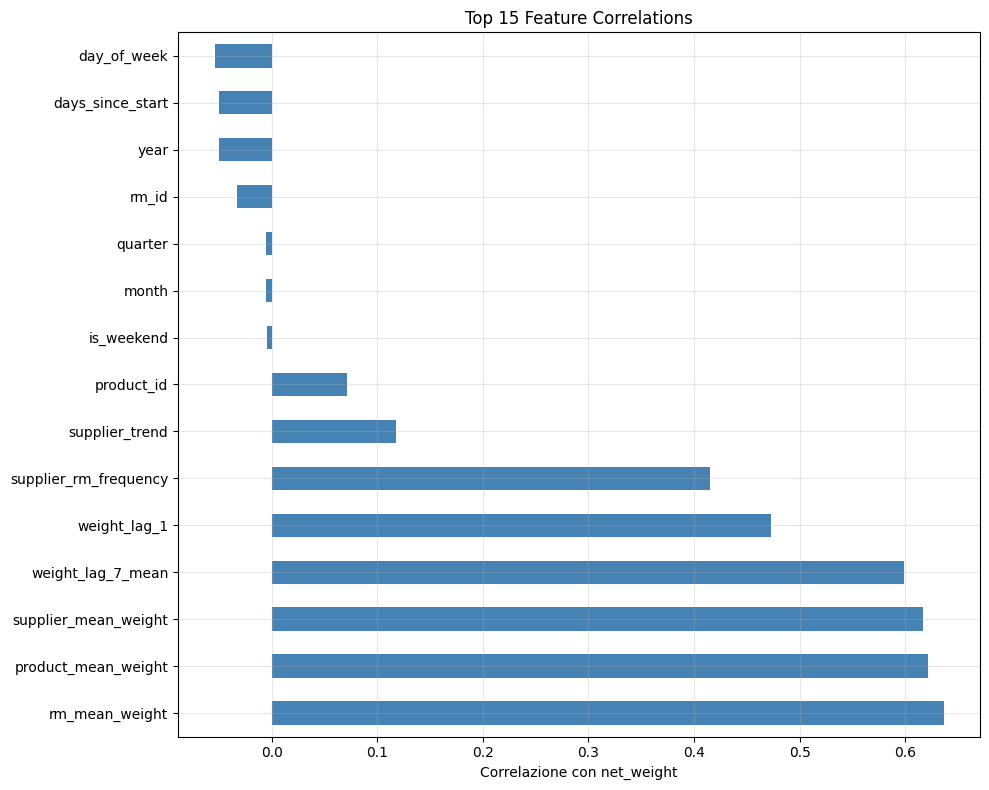

In [17]:
# Seleziona features numeriche per una prima analisi
feature_cols = [
    'supplier_id', 'rm_id', 'product_id',
    'year', 'month', 'day_of_week', 'is_weekend', 'quarter',
    'supplier_mean_weight', 'supplier_std_weight', 'supplier_cv',
    'weight_lag_1', 'weight_lag_7_mean', 'supplier_trend',
    'rm_mean_weight', 'product_mean_weight',
    'supplier_rm_frequency', 'days_since_start'
]

# Correlazione con il target
correlations = data_clean[feature_cols + ['net_weight']].corr()['net_weight'].sort_values(ascending=False)

print("\n📊 Correlazioni con net_weight:")
print(correlations)

# Visualizza top 15 correlazioni
plt.figure(figsize=(10, 8))
correlations[1:16].plot(kind='barh', color='steelblue')
plt.xlabel('Correlazione con net_weight')
plt.title('Top 15 Feature Correlations')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---

#### (optional) Final comparison between og and cleaned dataset

In [22]:
# 🔍 ANALISI: Confronto dataset originale vs pulito
print("=" * 60)
print("🔎 VERIFICA DATI ORIGINALI vs PULITI")
print("=" * 60)

# Carica il dataset originale
data_original = pd.read_csv('../data/kernel/receivals.csv')

print(f"\n📊 Dataset ORIGINALE:")
print(f"   Righe totali: {len(data_original)}")
print(f"   Colonne: {data_original.columns.tolist()}")

# Converti date nel dataset originale
data_original['date_arrival'] = pd.to_datetime(data_original['date_arrival'], format='%Y-%m-%d %H:%M:%S %z', utc=True, errors='coerce')
data_original['year'] = data_original['date_arrival'].dt.year

print(f"\n📅 Range temporale ORIGINALE:")
print(f"   Prima data: {data_original['date_arrival'].min()}")
print(f"   Ultima data: {data_original['date_arrival'].max()}")

# Distribuzione anni nel dataset originale
year_counts_orig = data_original['year'].value_counts().sort_index()

print(f"\n📊 Distribuzione per anno (ORIGINALE):")
print(year_counts_orig)

print(f"\n🔍 Confronto ORIGINALE vs PULITO:")
print(f"   Righe originali: {len(data_original)}")
print(f"   Righe dopo pulizia: {len(data_clean)}")
print(f"   Righe rimosse: {len(data_original) - len(data_clean)} ({(len(data_original) - len(data_clean))/len(data_original)*100:.1f}%)")

# Verifica dati 2020+ nell'originale
data_2020_plus_orig = data_original[data_original['year'] >= 2020]
data_2020_plus_clean = data_clean[data_clean['year'] >= 2020]

print(f"\n🔍 Dati dal 2020 in poi:")
print(f"   Nel dataset ORIGINALE: {len(data_2020_plus_orig)} record")
print(f"   Nel dataset PULITO: {len(data_2020_plus_clean)} record")

if len(data_2020_plus_orig) > 0 and len(data_2020_plus_clean) == 0:
    print(f"\n⚠️ PROBLEMA TROVATO: {len(data_2020_plus_orig)} record dal 2020 rimossi durante la pulizia!")
    print(f"\n📋 Campione dati 2020+ rimossi:")
    print(data_2020_plus_orig.head(10))
    
    # Analizza perché sono stati rimossi
    print(f"\n🔍 Analisi caratteristiche dati rimossi:")
    print(data_2020_plus_orig.describe())
    print(f"\nValori nulli nei dati 2020+:")
    print(data_2020_plus_orig.isnull().sum())
elif len(data_2020_plus_orig) == 0:
    print(f"\n✅ Il dataset originale non contiene dati dal 2020 in poi")
    print(f"   I dati si fermano effettivamente al 2018")
else:
    print(f"\n✅ I dati dal 2020 sono presenti anche nel dataset pulito")

🔎 VERIFICA DATI ORIGINALI vs PULITI

📊 Dataset ORIGINALE:
   Righe totali: 122590
   Colonne: ['rm_id', 'product_id', 'purchase_order_id', 'purchase_order_item_no', 'receival_item_no', 'batch_id', 'date_arrival', 'receival_status', 'net_weight', 'supplier_id']

📅 Range temporale ORIGINALE:
   Prima data: 2004-06-15 11:34:00+00:00
   Ultima data: 2024-12-19 13:36:00+00:00

📊 Distribuzione per anno (ORIGINALE):
year
2004    2167
2005    4309
2006    4759
2007    5028
2008    5278
2009    4742
2010    5576
2011    6055
2012    6217
2013    6566
2014    7125
2015    6229
2016    6285
2017    6386
2018    7215
2019    7248
2020    6600
2021    6522
2022    6513
2023    5752
2024    6018
Name: count, dtype: int64

🔍 Confronto ORIGINALE vs PULITO:
   Righe originali: 122590
   Righe dopo pulizia: 48878
   Righe rimosse: 73712 (60.1%)

🔍 Dati dal 2020 in poi:
   Nel dataset ORIGINALE: 31405 record
   Nel dataset PULITO: 0 record

⚠️ PROBLEMA TROVATO: 31405 record dal 2020 rimossi durante la pu

---

#### 5. Train/Test split

In [25]:
# Split temporale basato su percentile
# Ordina le date e prendi l'80° percentile
sorted_dates = data_clean['date_arrival'].sort_values()
cutoff_idx = int(len(sorted_dates) * 0.8)
cutoff_date = sorted_dates.iloc[cutoff_idx]

train_data = data_clean[data_clean['date_arrival'] < cutoff_date].copy()
test_data = data_clean[data_clean['date_arrival'] >= cutoff_date].copy()

print(f"\n📊 Train/Test Split:")
print(f"Cutoff date: {cutoff_date.date()}")
print(f"Training set: {len(train_data)} record ({train_data['date_arrival'].min().date()} to {train_data['date_arrival'].max().date()})")
print(f"Test set: {len(test_data)} record ({test_data['date_arrival'].min().date()} to {test_data['date_arrival'].max().date()})")
print(f"\nTrain/Test ratio: {len(train_data)/len(data_clean)*100:.1f}% / {len(test_data)/len(data_clean)*100:.1f}%")

# Verifica distribuzione target
print(f"\nTrain net_weight - Media: {train_data['net_weight'].mean():.2f}, Std: {train_data['net_weight'].std():.2f}")
print(f"Test net_weight - Media: {test_data['net_weight'].mean():.2f}, Std: {test_data['net_weight'].std():.2f}")

# Salva i dataset processati
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)
print("\n✅ Dataset salvati con successo!")


📊 Train/Test Split:
Cutoff date: 2016-07-13
Training set: 39102 record (2004-06-15 to 2016-07-13)
Test set: 9776 record (2016-07-13 to 2018-10-26)

Train/Test ratio: 80.0% / 20.0%

Train net_weight - Media: 12746.93, Std: 7927.55
Test net_weight - Media: 12794.89, Std: 8293.94

✅ Dataset salvati con successo!
